# Credit Card Fraud Detection — Advanced ANN Project

**Goal:** Build and evaluate advanced Artificial Neural Network(s) to detect fraudulent credit card transactions on the Kaggle dataset (`creditcard.csv`, ~285k transactions, ~0.17% fraud).  
**Focus:** Handling extreme class imbalance (class weights, SMOTE, undersampling), robust ANN architecture (Dropout, BatchNorm, L2), correct evaluation (ROC-AUC, PR-AUC), explainability (SHAP), and a production-ready saved model.

**Sections**
1. Setup & Imports  
2. Load Dataset & EDA  
3. Preprocessing  
4. Model builder (ANN)  
5. Experiments: Baseline, Class Weights, SMOTE, Undersampling  
6. Evaluation & Comparison  
7. Explainability (SHAP)  
8. Save Model & Prediction Cell  
9. Notes & Next Steps


1. Setup & Imports (Code)

In [ ]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from time import time

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import (
    confusion_matrix, classification_report,
    roc_curve, auc, precision_recall_curve,
    average_precision_score
)
from sklearn.linear_model import LogisticRegression
from sklearn.utils.class_weight import compute_class_weight

import tensorflow as tf
from keras.models import Sequential
from keras.layers import Dense, Dropout, BatchNormalization
from keras.regularizers import l2
from keras.callbacks import EarlyStopping, ReduceLROnPlateau

# For resampling
# from imblearn.over_sampling import SMOTE
# from imblearn.under_sampling import RandomUnderSampler

# For reproducibility
SEED = 42
np.random.seed(SEED)
tf.random.set_seed(SEED)

# Plot settings

plt.rcParams["figure.figsize"] = (8,5)


2. Load Dataset & Quick EDA

In [5]:
df = pd.read_csv('../data/creditcard.csv')

print(f"Dataset shape: {df.shape}")
print(df.head())

Dataset shape: (284807, 31)
   Time        V1        V2        V3        V4        V5        V6        V7  \
0   0.0 -1.359807 -0.072781  2.536347  1.378155 -0.338321  0.462388  0.239599   
1   0.0  1.191857  0.266151  0.166480  0.448154  0.060018 -0.082361 -0.078803   
2   1.0 -1.358354 -1.340163  1.773209  0.379780 -0.503198  1.800499  0.791461   
3   1.0 -0.966272 -0.185226  1.792993 -0.863291 -0.010309  1.247203  0.237609   
4   2.0 -1.158233  0.877737  1.548718  0.403034 -0.407193  0.095921  0.592941   

         V8        V9  ...       V21       V22       V23       V24       V25  \
0  0.098698  0.363787  ... -0.018307  0.277838 -0.110474  0.066928  0.128539   
1  0.085102 -0.255425  ... -0.225775 -0.638672  0.101288 -0.339846  0.167170   
2  0.247676 -1.514654  ...  0.247998  0.771679  0.909412 -0.689281 -0.327642   
3  0.377436 -1.387024  ... -0.108300  0.005274 -0.190321 -1.175575  0.647376   
4 -0.270533  0.817739  ... -0.009431  0.798278 -0.137458  0.141267 -0.206010   

    

### Quick checks
- `Time`: seconds since first transaction (can be engineered)  
- `V1` .. `V28`: PCA-transformed features (already anonymized)  
- `Amount`: transaction amount (not scaled)  
- `Class`: label (0 = normal, 1 = fraud)


In [6]:
print(df['Class'].value_counts())
df['Class'].value_counts(normalize=True).mul(100).round(4)

Class
0    284315
1       492
Name: count, dtype: int64


Class
0    99.8273
1     0.1727
Name: proportion, dtype: float64

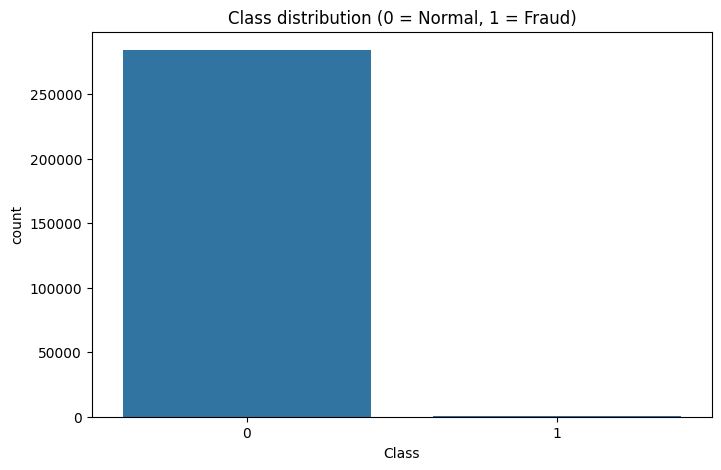

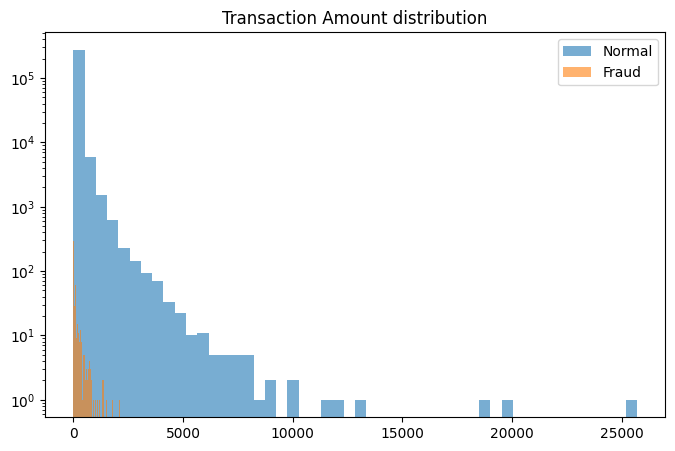

In [8]:
# Visualize class imbalance
sns.countplot(x='Class', data=df)
plt.title('Class distribution (0 = Normal, 1 = Fraud)')
plt.show()

# Amount distribution (log scale to visualize)
plt.hist(df[df['Class']==0]['Amount'], bins=50, alpha=0.6, label='Normal')
plt.hist(df[df['Class']==1]['Amount'], bins=50, alpha=0.6, label='Fraud')
plt.legend()
plt.title('Transaction Amount distribution')
plt.yscale('log')
plt.show()


3. Preprocessing (Scaling + Train/Test split)

In [10]:
# Feature and target separation

x = df.drop(['Class'],axis=1)
y = df['Class'].values  

scaler = StandardScaler()
x['scaled_amount'] = scaler.fit_transform(x['Amount'].values.reshape(-1,1))
x['scaled_time'] = scaler.fit_transform(x['Time'].values.reshape(-1,1))
x = x.drop(['Time','Amount'],axis=1)

x_values = x.values
print(f"Feature set shape: {x_values.shape}")
print(f"Target set shape: {y.shape}")

x_train,x_test,y_train,y_test = train_test_split(
    x_values,y,test_size=0.2,random_state=SEED,stratify=y
)

print(f"Training set shape: {x_train.shape}, {y_train.shape}")
print(f"Testing set shape: {x_test.shape}, {y_test.shape}")

Feature set shape: (284807, 30)
Target set shape: (284807,)
Training set shape: (227845, 30), (227845,)
Testing set shape: (56962, 30), (56962,)


4. ANN Builder Function

In [13]:
def build_model(input_dim,l2_reg=1e-4,dropout_rate=0.3):
    model = Sequential()

    model.add(Dense(64,activation='relu',input_dim=input_dim,kernel_regularizer=l2(l2_reg)))
    model.add(BatchNormalization())
    model.add(Dropout(dropout_rate))

    model.add(Dense(32,activation='relu',kernel_regularizer=l2(l2_reg)))
    model.add(BatchNormalization())
    model.add(Dropout(dropout_rate))

    model.add(Dense(16,activation='relu',kernel_regularizer=l2(l2_reg)))
    model.add(BatchNormalization())
    model.add(Dropout(dropout_rate))

    model.add(Dense(1,activation='sigmoid'))

    model.compile(optimizer='adam',loss='binary_crossentropy',metrics=['accuracy'])

    return model

model = build_model(input_dim=x_train.shape[1])
model.summary()                                                                                     

Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_4 (Dense)                 │ (None, 64)             │         1,984 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_2           │ (None, 64)             │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ (None, 32)             │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_3           │ (None, 32)             │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ (None, 32)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_6 (Dense)                 │ (None, 16)             │           528 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_4           │ (None, 16)             │            64 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_4 (Dropout)             │ (None, 16)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_7 (Dense)                 │ (None, 1)              │            17 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 5,057 (19.75 KB)

 Trainable params: 4,833 (18.88 KB)

 Non-trainable params: 224 (896.00 B)

5. Utility: Training & Evaluation Helpers

In [14]:
def fit_model(model, X_tr, y_tr, X_val, y_val, epochs=150, batch_size=2048, class_weight=None):
    early_stopping = EarlyStopping(
        monitor='val_loss', patience=5, restore_best_weights=True
    )
    reduce_lr = ReduceLROnPlateau(
        monitor='val_loss', factor=0.5, patience=3, min_lr=1e-6
    )

    history = model.fit(
        X_tr, y_tr,
        validation_data=(X_val, y_val),
        epochs=epochs,
        batch_size=batch_size,
        class_weight=class_weight,
        callbacks=[early_stopping, reduce_lr],
        verbose=1
    )

    return history

def evaluate_model(model, X_te, y_te, threshold=0.5, show_plots=True):
    y_proba = model.predict(X_te).ravel()
    y_pred = (y_proba >= threshold).astype(int)
    print("Classification Report:")
    print(classification_report(y_te, y_pred, digits=4))
    cm = confusion_matrix(y_te, y_pred)
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['Normal','Fraud'], yticklabels=['Normal','Fraud'])
    plt.title(f'Confusion Matrix (threshold={threshold})')
    plt.show()

    # ROC
    fpr, tpr, _ = roc_curve(y_te, y_proba)
    roc_auc = auc(fpr, tpr)
    print(f"ROC AUC: {roc_auc:.4f}")

    # Precision-Recall and AP
    precision, recall, _ = precision_recall_curve(y_te, y_proba)
    ap = average_precision_score(y_te, y_proba)
    print(f"PR-AUC (Average Precision): {ap:.4f}")
    if show_plots:
        plt.figure()
        plt.plot(fpr, tpr, label=f'ROC AUC = {roc_auc:.4f}')
        plt.plot([0,1],[0,1],'k--')
        plt.xlabel('False Positive Rate')
        plt.ylabel('True Positive Rate')
        plt.title('ROC Curve')
        plt.legend()
        plt.show()

        plt.figure()
        plt.plot(recall, precision, label=f'AP = {ap:.4f}')
        plt.xlabel('Recall')
        plt.ylabel('Precision')
        plt.title('Precision-Recall Curve')
        plt.legend()
        plt.show()

    return y_proba

6. Experiment A — Baseline ANN (No imbalance handling)